In [142]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt

In [144]:
networkpatterns = pd.read_csv('unlabeled_network_data.csv')
networkpatterns.head(10)

,timestamp,bandwidth_in (kb),bandwidth_out (kb),jenis_probo,ping
0,2024-12-01 00:00:00,1924,509,ftp,28.23
1,2024-12-01 00:00:15,2386,1779,ftp,74.33
2,2024-12-01 00:01:10,1524,9774,http,4.15
3,2024-12-01 00:00:18,3682,3911,https,60.60
4,2024-12-01 00:02:24,3357,11831,ftp,70.43
5,2024-12-01 00:02:15,3711,7459,https,28.54
6,2024-12-01 00:05:36,206,2715,ftp,42.84
7,2024-12-01 00:02:06,2647,3627,dns,34.32
8,2024-12-01 00:00:48,6324,1684,icmp,84.90
9,2024-12-01 00:05:51,4433,811,ftp,46.48


In [145]:
networkpatterns.tail(10)

,timestamp,bandwidth_in (kb),bandwidth_out (kb),jenis_probo,ping
8105,2024-12-23 08:00:00,4410,11341,icmp,116.97
8106,2024-12-11 05:00:00,7075,3133,https,164.85
8107,2024-12-18 19:00:00,8618,5062,http,102.18
8108,2024-12-18 09:00:00,1951,4941,icmp,30.18
8109,2024-12-23 07:00:00,6899,2162,icmp,28.15
8110,2024-12-16 10:00:00,4047,11699,tcp,49.20
8111,2024-12-20 17:00:00,6874,1240,https,100.49
8112,2024-12-15 04:00:00,10656,7533,tcp,190.19
8113,2024-12-15 16:00:00,5979,3019,https,54.42
8114,2024-12-12 22:00:00,2136,1176,tcp,48.59


In [146]:
networkpatterns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8115 entries, 0 to 8114
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   timestamp           8115 non-null   object 
 1   bandwidth_in (kb)   8115 non-null   int64  
 2   bandwidth_out (kb)  8115 non-null   int64  
 3   jenis_probo         8115 non-null   object 
 4   ping                8115 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 317.1+ KB


In [148]:
networkpatterns = networkpatterns.fillna(value=0)

In [149]:
# === 1. Normalisasi Data ===
# Hanya kolom 'bandwidth_in (kb)', 'bandwidth_out (kb)', dan 'ping'
x_networkpatterns = networkpatterns[['bandwidth_in (kb)', 'bandwidth_out (kb)', 'ping']]
scaler = MinMaxScaler()
x_normalized = scaler.fit_transform(x_networkpatterns)

In [150]:
# === 2. Tentukan jumlah kluster optimal menggunakan Elbow Method dan Silhouette Score ===
inertia = []
silhouette_scores = []
k_values = range(2, 10)  # Evaluasi untuk k dari 2 hingga 9

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(x_normalized)
    
    # Menghitung inertia untuk Elbow Method
    inertia.append(kmeans.inertia_)
    
    # Menghitung Silhouette Score
    score = silhouette_score(x_normalized, cluster_labels)
    silhouette_scores.append(score)

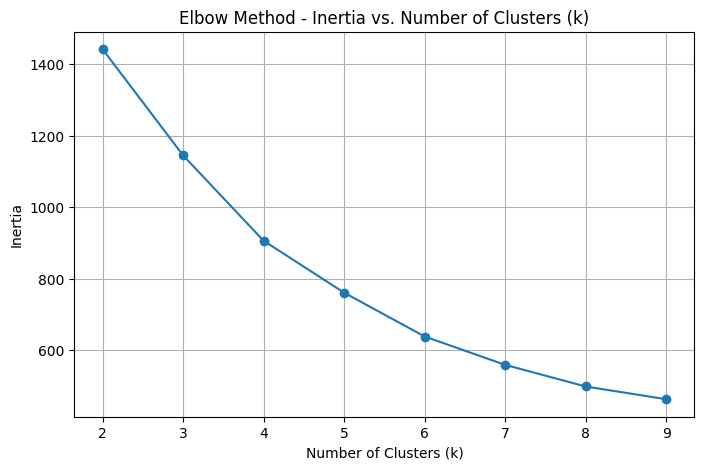

In [151]:
# Plot Elbow Method (Inertia)
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o')
plt.title("Elbow Method - Inertia vs. Number of Clusters (k)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.xticks(k_values)
plt.grid(True)
plt.show()

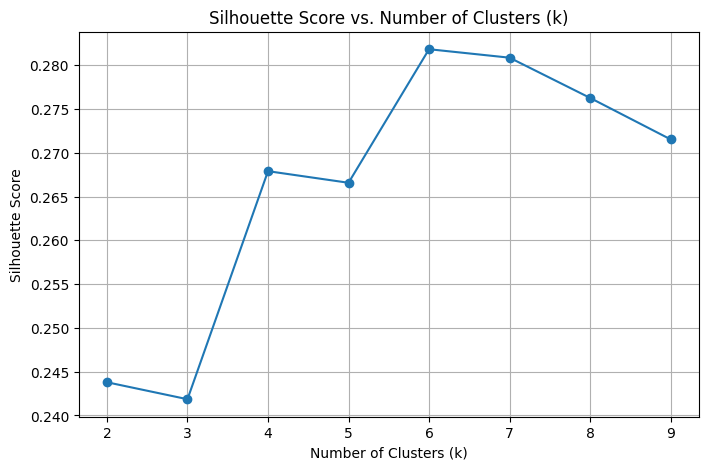

In [152]:
# Plot Silhouette Score
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title("Silhouette Score vs. Number of Clusters (k)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.xticks(k_values)
plt.grid(True)
plt.show()

In [153]:
# Pilih k dengan inertia terendah atau silhouette score tertinggi
optimal_k = k_values[np.argmax(silhouette_scores)]  # Bisa juga berdasarkan inertia
print(f"Optimal number of clusters (k) berdasarkan Silhouette Score: {optimal_k}")

Optimal number of clusters (k) berdasarkan Silhouette Score: 6


In [155]:
# === 3. Implementasi K-Means dengan k optimal ===
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
networkpatterns['Cluster'] = kmeans.fit_predict(x_normalized)

In [160]:
# === 4. Analisis Centroid Kluster ===
centroids = kmeans.cluster_centers_
print("Centroid Kluster:\n", centroids)

cluster_bandwidth_totals = centroids[:, 0] + centroids[:, 1]
flood_cluster = np.argmax(cluster_bandwidth_totals)  # Kluster dengan total bandwidth tertinggi
normal_cluster = 1 - flood_cluster  # Kluster lainnya adalah "Normal"

# Mapping kluster ke deskripsi
cluster_labels = {normal_cluster: 'Normal', flood_cluster: 'Flood'}
networkpatterns['Label'] = networkpatterns['Cluster'].map(cluster_labels)
networkpatterns['Label'] = np.where(networkpatterns['Cluster'] < 5, 'Normal', 'Flood')

Centroid Kluster:
 [[0.2871726  0.67795365 0.79463195]
 [0.70188895 0.25470726 0.2380842 ]
 [0.2214268  0.22090462 0.34413723]
 [0.70162477 0.3305414  0.78022439]
 [0.7547933  0.75213046 0.35295531]
 [0.2550769  0.70776383 0.24928117]]


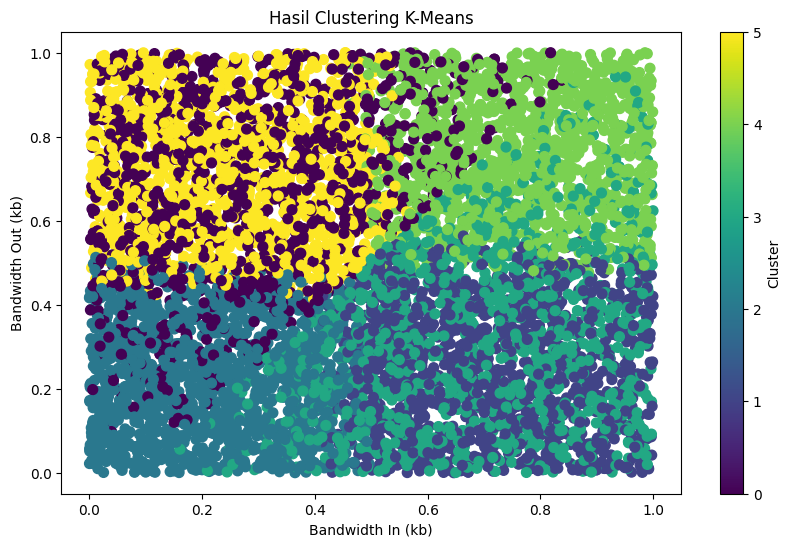

In [161]:
# === 4. Visualisasi ===
# Visualisasi hasil clustering
plt.figure(figsize=(10, 6))
plt.scatter(
    x_normalized[:, 0], x_normalized[:, 1],
    c=networkpatterns['Cluster'], cmap='viridis', s=50
)
plt.title("Hasil Clustering K-Means")
plt.xlabel("Bandwidth In (kb)")
plt.ylabel("Bandwidth Out (kb)")
plt.colorbar(label="Cluster")
plt.show()

In [163]:
# === 5. Evaluasi Setelah Mapping ===
print("\nData setelah mapping kluster:")
print(networkpatterns.head())


Data setelah mapping kluster:
             timestamp  bandwidth_in (kb)  bandwidth_out (kb) jenis_probo  \
0  2024-12-01 00:00:00               1924                 509         ftp   
1  2024-12-01 00:00:15               2386                1779         ftp   
2  2024-12-01 00:01:10               1524                9774        http   
3  2024-12-01 00:00:18               3682                3911       https   
4  2024-12-01 00:02:24               3357               11831         ftp   

    ping  Cluster Keterangan   Label  
0  28.23        2     Normal  Normal  
1  74.33        2     Normal  Normal  
2   4.15        5      Flood   Flood  
3  60.60        2     Normal  Normal  
4  70.43        5      Flood   Flood  


In [165]:
# Membuat objek RandomUnderSampler
under_sampler = RandomUnderSampler(random_state=42)

# Melakukan undersampling untuk kelas mayoritas
x_resampled, y_resampled = under_sampler.fit_resample(x_normalized, networkpatterns['Label'])

c:\Users\naufa\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\naufa\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
c:\Users\naufa\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


C:\Users\naufa\AppData\Local\Temp\ipykernel_12328\794235321.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')


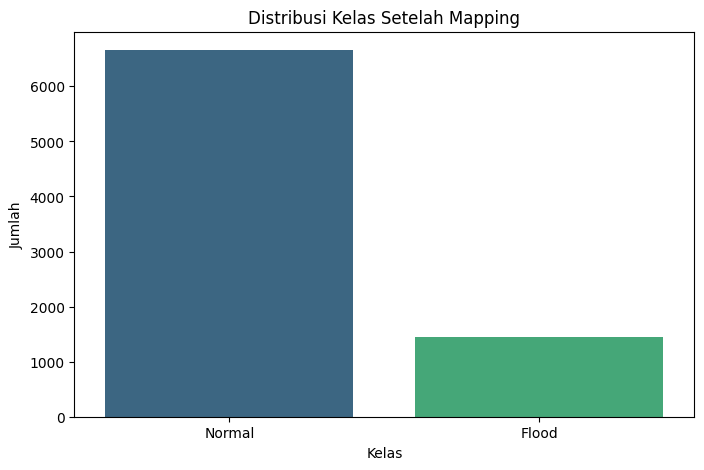

In [166]:
# Hitung jumlah masing-masing kelas
label_counts = networkpatterns['Label'].value_counts()

# Plot bar chart
plt.figure(figsize=(8, 5))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')

# Menambahkan judul dan label
plt.title("Distribusi Kelas Setelah Mapping")
plt.xlabel("Kelas")
plt.ylabel("Jumlah")
plt.show()

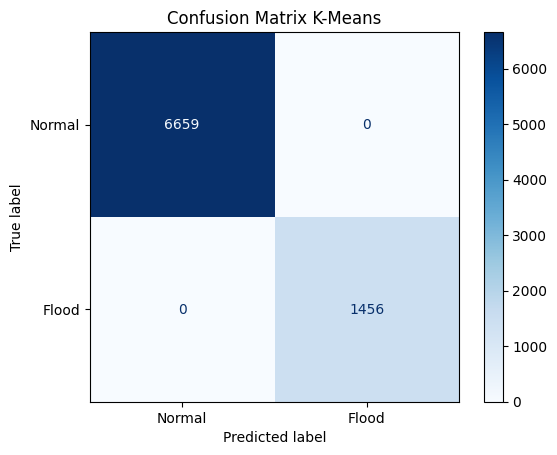

In [167]:
conf_matrix = confusion_matrix(networkpatterns['Label'] == 'Flood', networkpatterns['Keterangan'] == 'Flood')

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Normal', 'Flood'])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix K-Means")
plt.show()